In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [3]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [4]:
N_YEARS = 10
N_CUTS = 4
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = str(TODAY - timedelta(N_DAYS))  # '1996-01-01' #
START, TODAY

('2012-04-17', datetime.date(2022, 4, 17))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


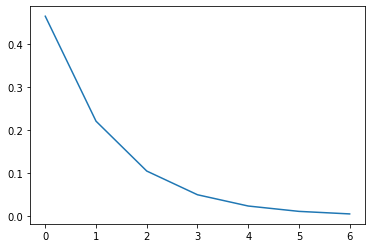

In [5]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [6]:
SD = SDS[(TODAY.weekday() + 1) % 7] # 0 (largest SD) on Sat
SD

0.46566128730773904

In [7]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = [
    '^GSPC', # S&P 500
    '^IXIC', # Nasdaq
    '^NYA',  # NY Stock Exchange (total)
    '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [8]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [9]:
cols = [
    (first, second)
    for first in ['Value', 'Close', 'High', 'Low', 'Open'] 
    for second in ['mine1', 'mine2']]
cols

[('Value', 'mine1'),
 ('Value', 'mine2'),
 ('Close', 'mine1'),
 ('Close', 'mine2'),
 ('High', 'mine1'),
 ('High', 'mine2'),
 ('Low', 'mine1'),
 ('Low', 'mine2'),
 ('Open', 'mine1'),
 ('Open', 'mine2')]

In [10]:
mine = pd.read_csv('../data/mine.csv')
#mine.mine1.iloc[-300:] = 8.1
mine.index = pd.to_datetime(mine['Date'])
mine.drop(columns='Date', inplace=True)
mine['cmine1'] = mine.mine1
mine['cmine2'] = mine.mine2
mine['hmine1'] = mine.mine1
mine['hmine2'] = mine.mine2
mine['lmine1'] = mine.mine1
mine['lmine2'] = mine.mine2
mine['omine1'] = mine.mine1
mine['omine2'] = mine.mine2
mine.columns = pd.MultiIndex.from_tuples(cols)
mine.tail()

Value                Close                 High            \
                mine1     mine2      mine1     mine2      mine1     mine2   
Date                                                                        
2022-04-08  19.043186  7.402860  19.043186  7.402860  19.043186  7.402860   
2022-04-11  18.852863  7.262342  18.852863  7.262342  18.852863  7.262342   
2022-04-12  18.689837  7.176103  18.689837  7.176103  18.689837  7.176103   
2022-04-13  19.243916  7.359597  19.243916  7.359597  19.243916  7.359597   
2022-04-14  18.657302  7.120408  18.657302  7.120408  18.657302  7.120408   

                  Low                 Open            
                mine1     mine2      mine1     mine2  
Date                                                  
2022-04-08  19.043186  7.402860  19.043186  7.402860  
2022-04-11  18.852863  7.262342  18.852863  7.262342  
2022-04-12  18.689837  7.176103  18.689837  7.176103  
2022-04-13  19.243916  7.359597  19.243916  7.359597  
2022-04-14  18.657302  7.120408  18.657302  7.120408

In [11]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download(append=mine)

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000
   ...mine1
   ...mine2


In [12]:
data.head()

Value                                                Close  \
         ^GSPC        ^IXIC         ^NYA        ^W5000        ^GSPC   
0  1390.780029  3042.820068  8064.040039  14603.469727  1390.780029   
1  1385.140015  3031.449951  8030.370117  14542.269531  1385.140015   
2  1376.920044  3007.560059  7995.910156  14467.419922  1376.920044   
3  1378.530029  3000.449951  8025.439941  14488.099609  1378.530029   
4  1366.939941  2970.449951  7940.740234  14350.580078  1366.939941   

                                                  High               ...  \
         ^IXIC         ^NYA        ^W5000        ^GSPC        ^IXIC  ...   
0  3042.820068  8064.040039  14603.469727  1392.760010  3052.760010  ...   
1  3031.449951  8030.370117  14542.269531  1390.780029  3045.040039  ...   
2  3007.560059  7995.910156  14467.419922  1390.459961  3058.719971  ...   
3  3000.449951  8025.439941  14488.099609  1387.400024  3034.689941  ...   
4  2970.449951  7940.740234  14350.580078  1378.530029  2973.379883  ...   

  DayToDayChange OvernightChange  LogValue IntradayChange DayToDayChange  \
          ^W5000          ^W5000     mine1          mine1          mine1   
0            NaN             NaN  0.011840            1.0            NaN   
1       0.995809             1.0  0.006415            1.0       0.994589   
2       0.994853             1.0 -0.002226            1.0       0.991396   
3       1.001429             1.0 -0.005564            1.0       0.996668   
4       0.990508             1.0 -0.013576            1.0       0.992021   

  OvernightChange  LogValue IntradayChange DayToDayChange OvernightChange  
            mine1     mine2          mine2          mine2           mine2  
0             NaN  0.011840            1.0            NaN             NaN  
1        0.994589  0.006465            1.0       0.994640        0.994640  
2        0.991396 -0.002154            1.0       0.991417        0.991417  
3        0.996668 -0.005253            1.0       0.996907        0.996907  
4        0.992021 -0.013069            1.0       0.992214        0.992214  

[5 rows x 55 columns]

In [13]:
data['Date'].tail()

2512   2022-04-08
2513   2022-04-11
2514   2022-04-12
2515   2022-04-13
2516   2022-04-14
Name: Date, dtype: datetime64[ns]

In [14]:
data.index = pd.to_datetime(data['Date'])
data.head()

Value                                                Close  \
                  ^GSPC        ^IXIC         ^NYA        ^W5000        ^GSPC   
Date                                                                           
2012-04-17  1390.780029  3042.820068  8064.040039  14603.469727  1390.780029   
2012-04-18  1385.140015  3031.449951  8030.370117  14542.269531  1385.140015   
2012-04-19  1376.920044  3007.560059  7995.910156  14467.419922  1376.920044   
2012-04-20  1378.530029  3000.449951  8025.439941  14488.099609  1378.530029   
2012-04-23  1366.939941  2970.449951  7940.740234  14350.580078  1366.939941   

                                                           High               \
                  ^IXIC         ^NYA        ^W5000        ^GSPC        ^IXIC   
Date                                                                           
2012-04-17  3042.820068  8064.040039  14603.469727  1392.760010  3052.760010   
2012-04-18  3031.449951  8030.370117  14542.269531  1390.780029  3045.040039   
2012-04-19  3007.560059  7995.910156  14467.419922  1390.459961  3058.719971   
2012-04-20  3000.449951  8025.439941  14488.099609  1387.400024  3034.689941   
2012-04-23  2970.449951  7940.740234  14350.580078  1378.530029  2973.379883   

            ... DayToDayChange OvernightChange  LogValue IntradayChange  \
            ...         ^W5000          ^W5000     mine1          mine1   
Date        ...                                                           
2012-04-17  ...            NaN             NaN  0.011840            1.0   
2012-04-18  ...       0.995809             1.0  0.006415            1.0   
2012-04-19  ...       0.994853             1.0 -0.002226            1.0   
2012-04-20  ...       1.001429             1.0 -0.005564            1.0   
2012-04-23  ...       0.990508             1.0 -0.013576            1.0   

           DayToDayChange OvernightChange  LogValue IntradayChange  \
                    mine1           mine1     mine2          mine2   
Date                                                                 
2012-04-17            NaN             NaN  0.011840            1.0   
2012-04-18       0.994589        0.994589  0.006465            1.0   
2012-04-19       0.991396        0.991396 -0.002154            1.0   
2012-04-20       0.996668        0.996668 -0.005253            1.0   
2012-04-23       0.992021        0.992021 -0.013069            1.0   

           DayToDayChange OvernightChange  
                    mine2           mine2  
Date                                       
2012-04-17            NaN             NaN  
2012-04-18       0.994640        0.994640  
2012-04-19       0.991417        0.991417  
2012-04-20       0.996907        0.996907  
2012-04-23       0.992214        0.992214  

[5 rows x 55 columns]

In [15]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [16]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [17]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(
            f'Unexpected error getting {stock} data. Initialized as '
            f'None.')

In [18]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [19]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'w') as f:
        json.dump(best_param_set, f)

In [20]:
SDS

array([0.46566129, 0.2213282 , 0.10519701, 0.05      , 0.02376493,
       0.01129544, 0.00536871])

SD: 0.2213282



----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.35546553409469
Refitting current best...
Current best ma returns: 2.4957024813173683
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 2.4957030220406207
Invested: 1.0
New best: 2.495703037250726
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.35546553409469
Refitting current best...
Current best ew_ma returns: 2.496714101839327
Fraction Invested: 0.999656773146526
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 2.35546

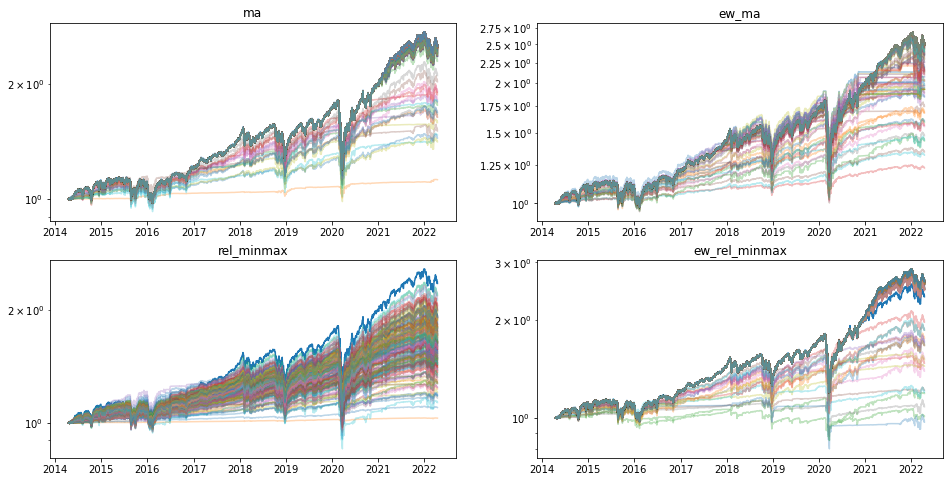

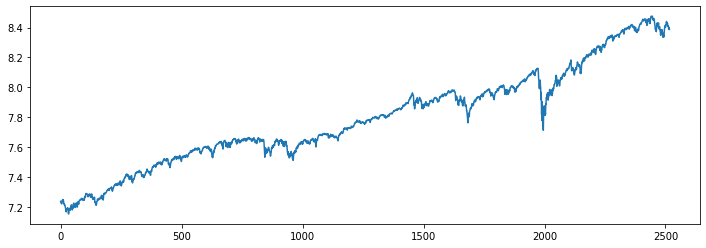

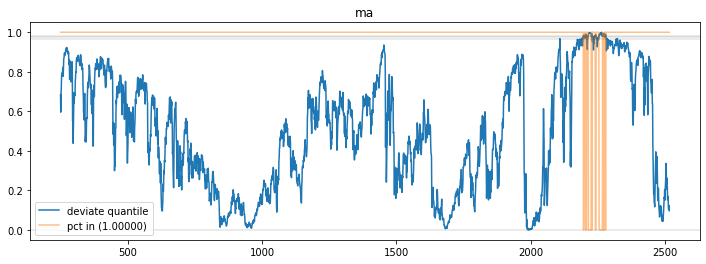

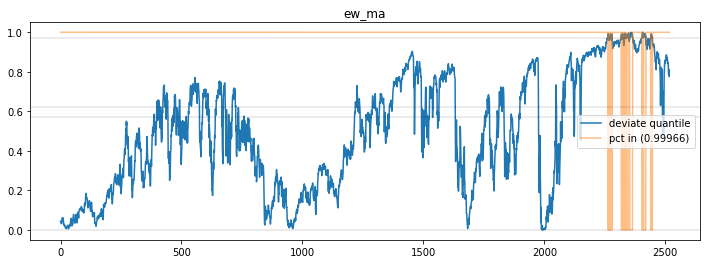

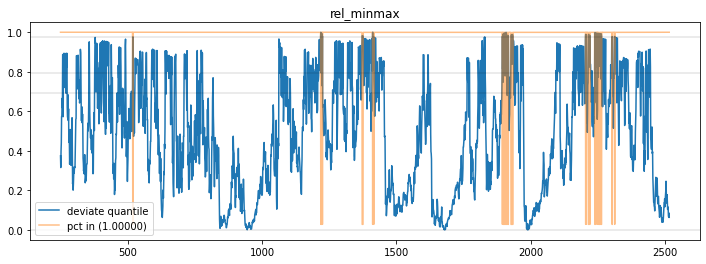

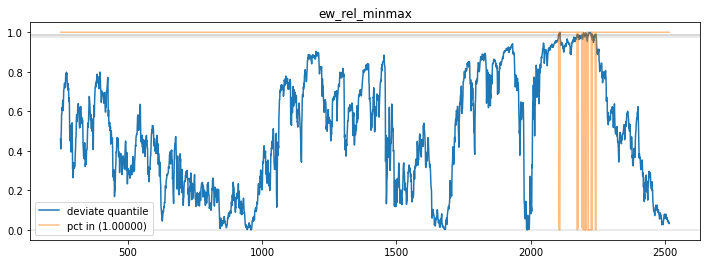

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.2599230413853744
Refitting current best...
Current best ma returns: 3.6334844033284424
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.2599230413853744
Refitting current best...
Current best ew_ma returns: 3.7977225301105015
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 3.798372087642354
Invested: 1.0
New best: 3.798411580114156
Invested: 1.0
New best: 3.798417557820004
Invested: 1.0
Round: 180


Beginning rel_minmax method...
-------------------------------------

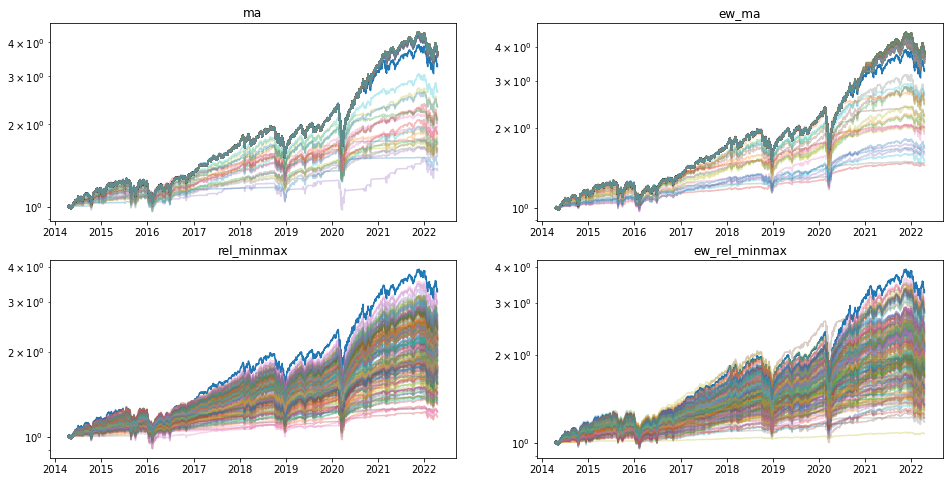

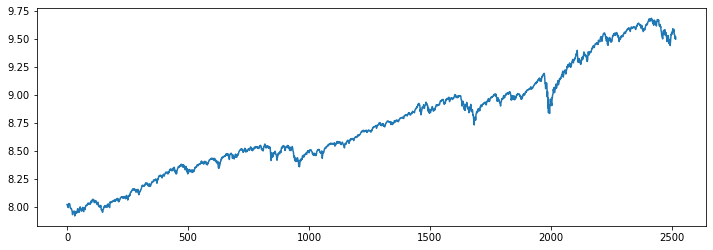

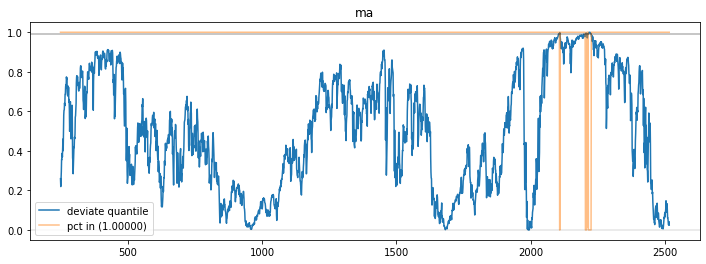

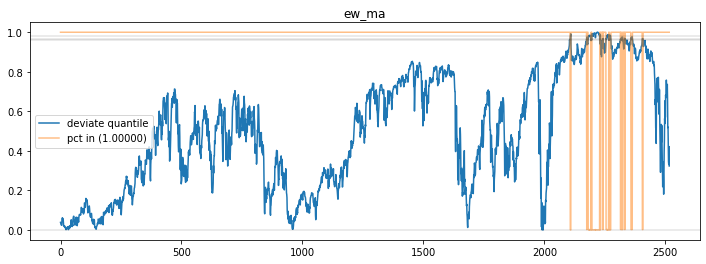

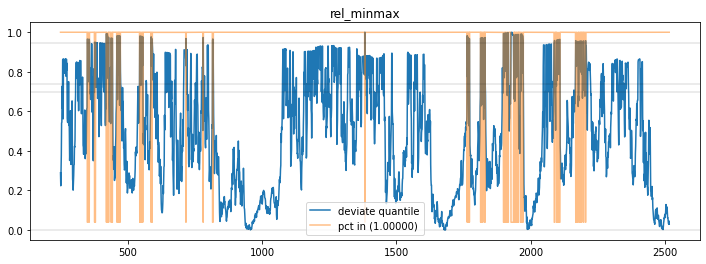

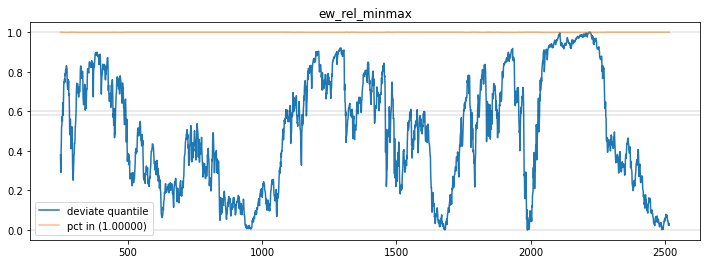

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.5676232924251536
Refitting current best...
Current best ma returns: 1.6173509118473408
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.5676232924251536
Refitting current best...
Current best ew_ma returns: 1.607010372903879
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 1.5676232924251536
Refitting current best...
Fraction Invested: 1
Beginning random search...
R

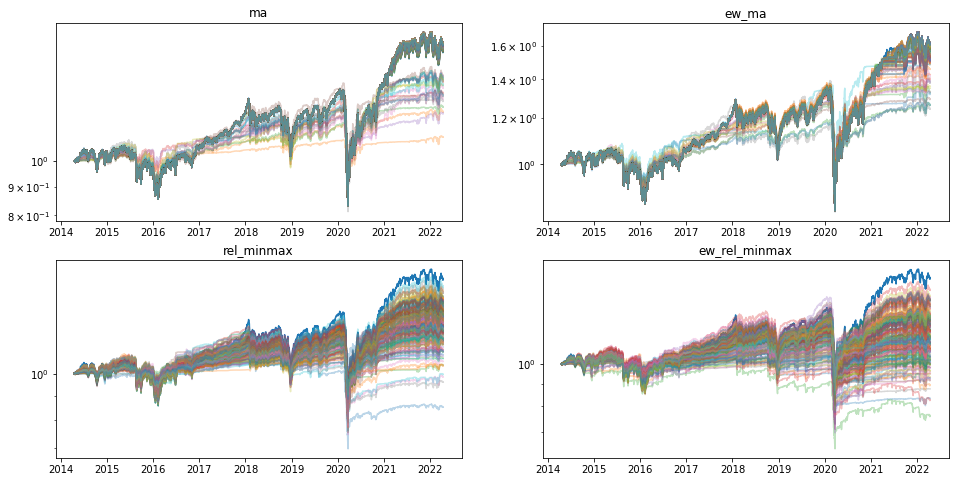

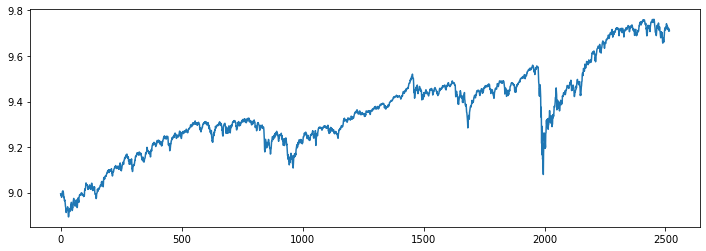

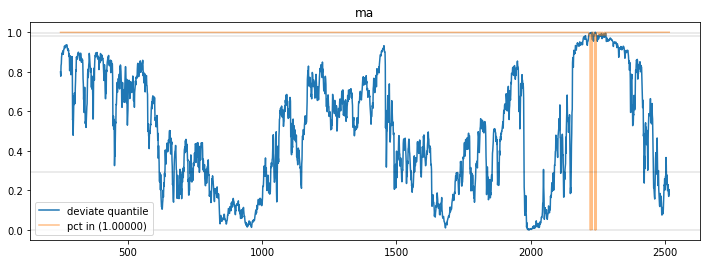

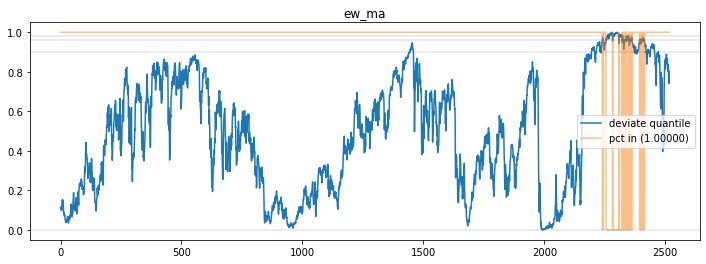

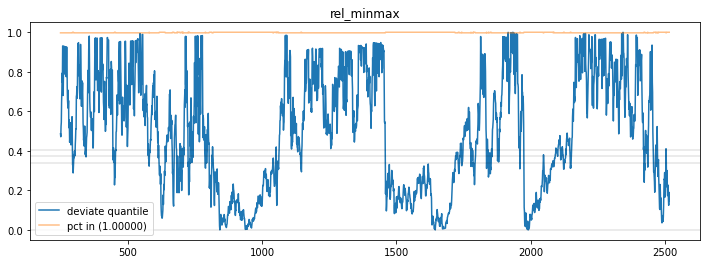

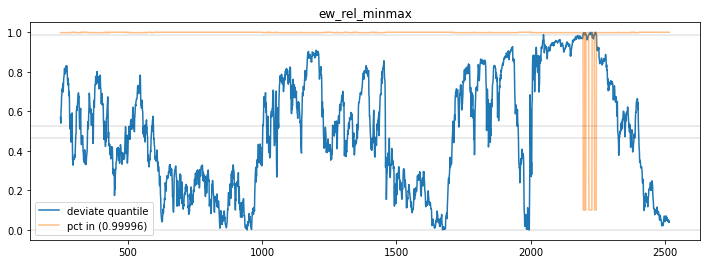

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.2277377357996295
Refitting current best...
Current best ma returns: 2.420524601708521
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 2.4205246694841795
Invested: 1.0
New best: 2.4205262257791564
Invested: 1.0
New best: 2.42052628788015
Invested: 1.0
New best: 2.420526764298755
Invested: 1.0
New best: 2.420532445614287
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.2277377357996295
Refitting current best...
Current best ew_ma returns: 2.573416762407595
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search..

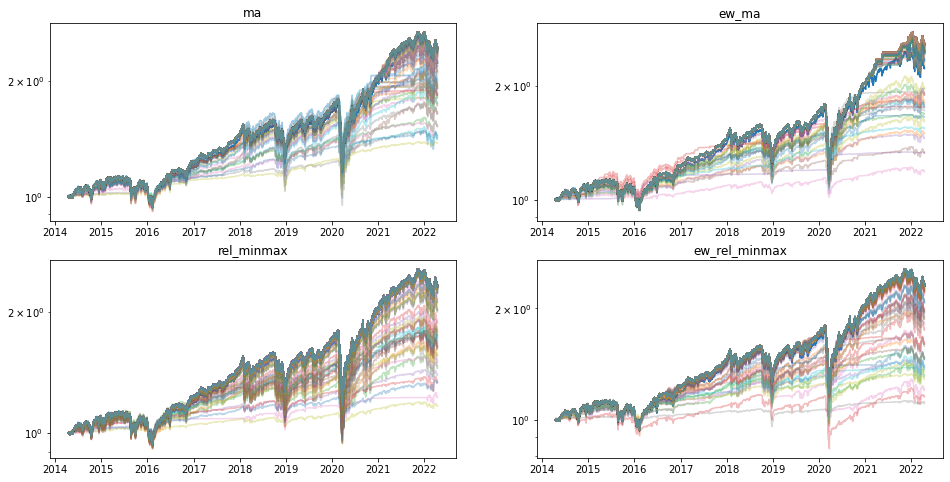

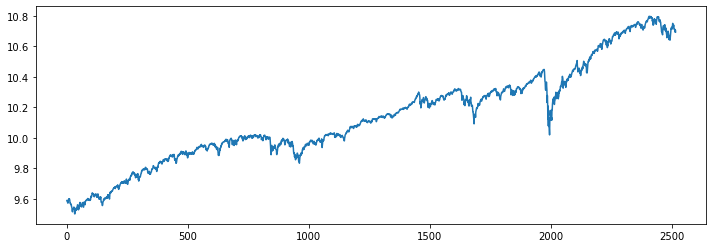

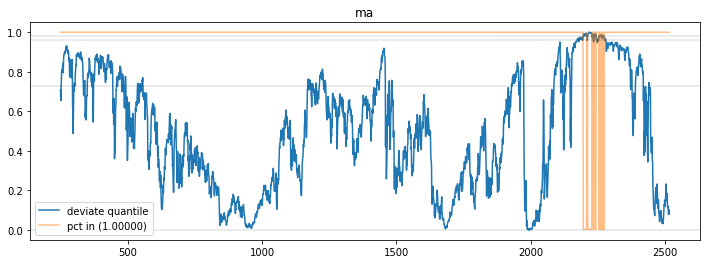

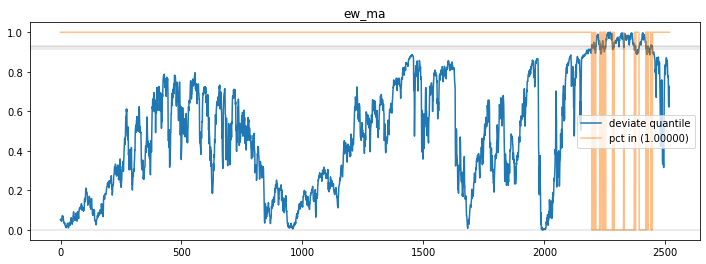

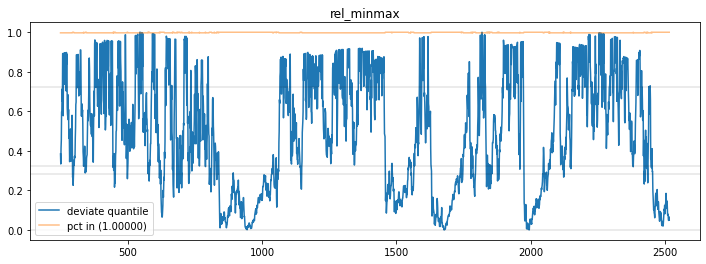

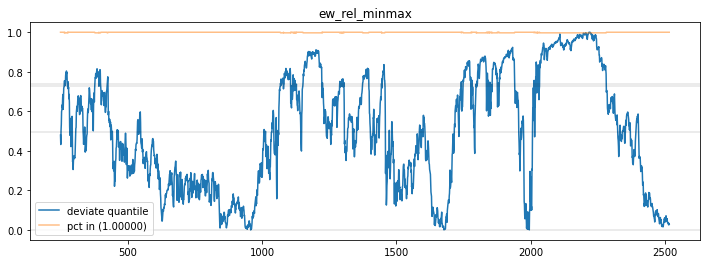

Saving ^W5000 params...



----------------------------------------------------------------------
                                 mine1
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 12.923478956244839
Refitting current best...
Current best ma returns: 14.283156975764483
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 14.283198168468495
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 12.923478956244839
Refitting current best...
Current best ew_ma returns: 15.36588050499838
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 15.365887188829788
Invested: 1.0
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 12.923

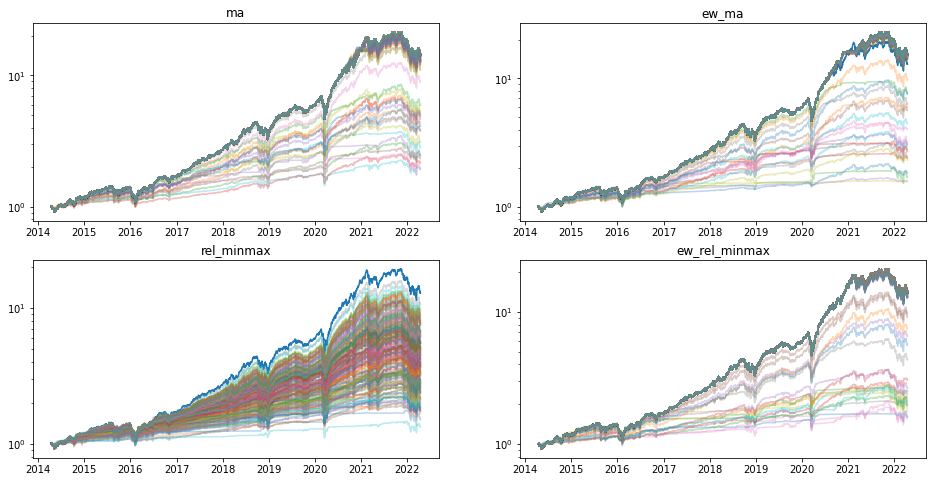

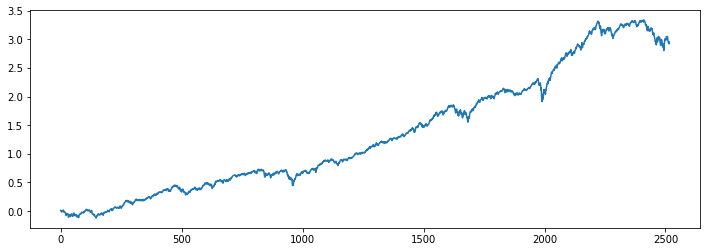

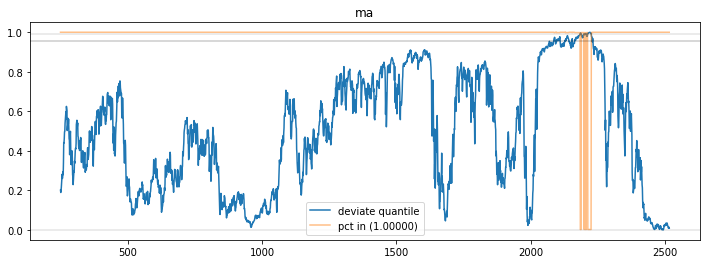

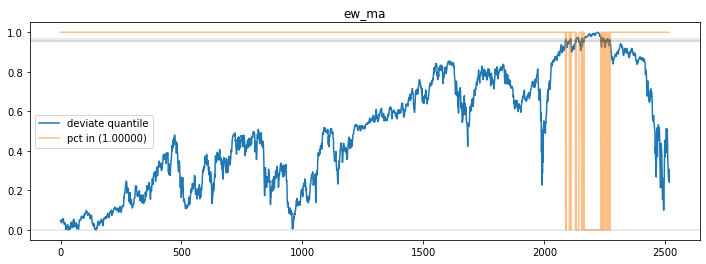

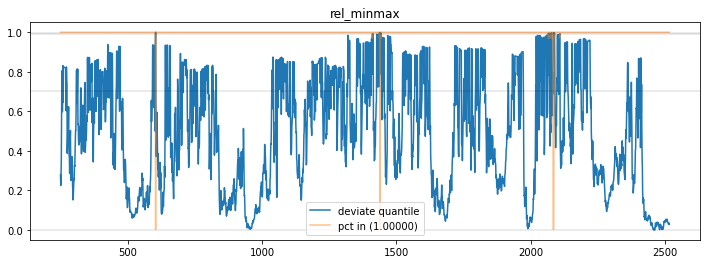

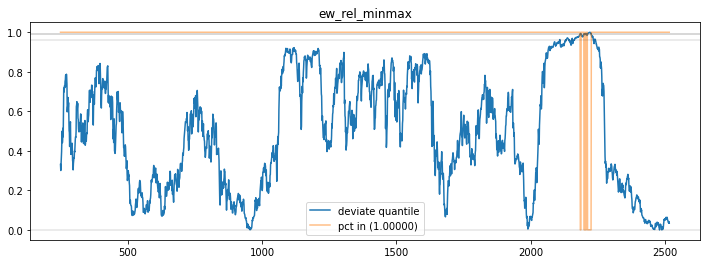

Saving mine1 params...



----------------------------------------------------------------------
                                 mine2
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 4.938383252658185
Refitting current best...
Current best ma returns: 6.469234784075519
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 6.471501191280749
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 4.938383252658185
Refitting current best...
Current best ew_ma returns: 7.137767233058704
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 7.13787376359552
Invested: 1.0
New best: 7.137874073697759
Invested: 1.0
New best: 7.138196768382973
Invested: 1.0
New best: 7.1381969398742875
Invested: 1.0
R

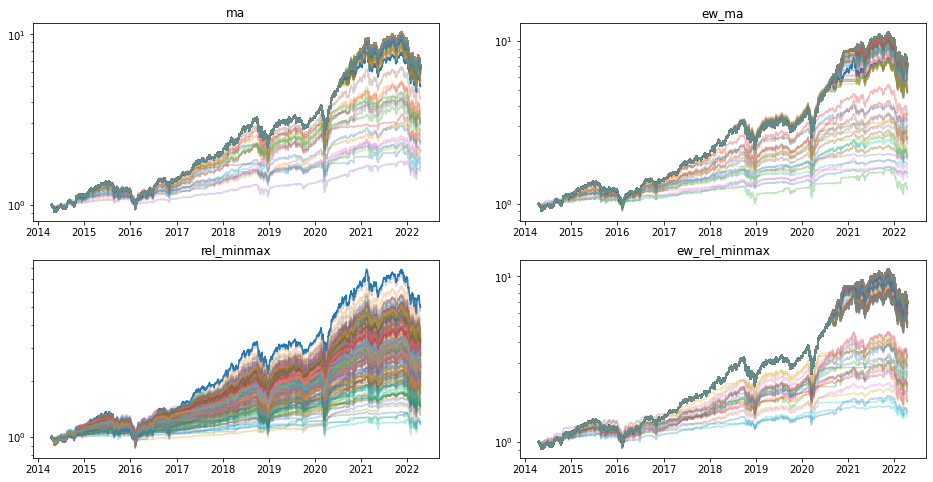

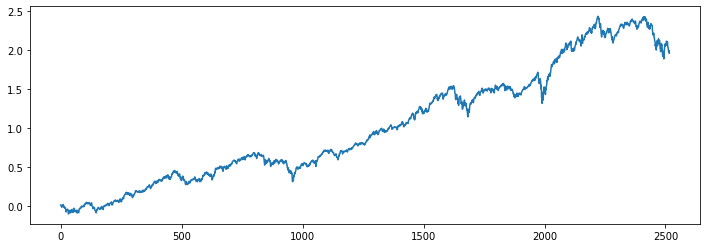

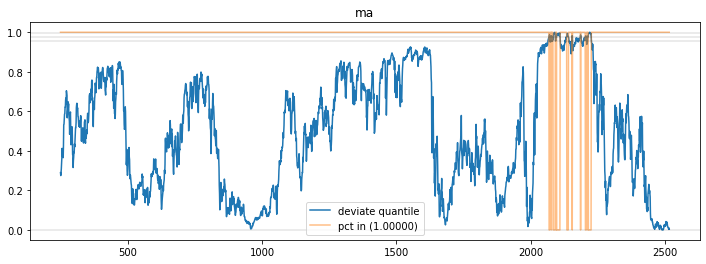

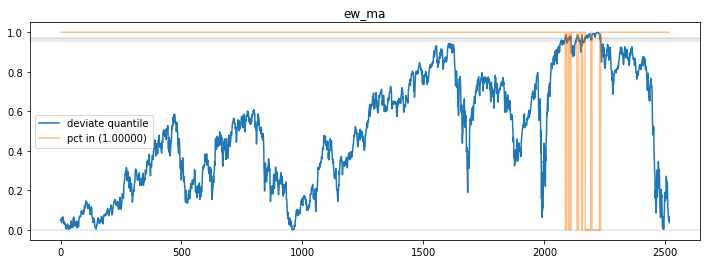

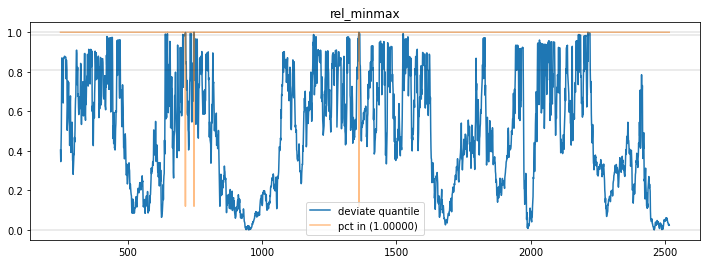

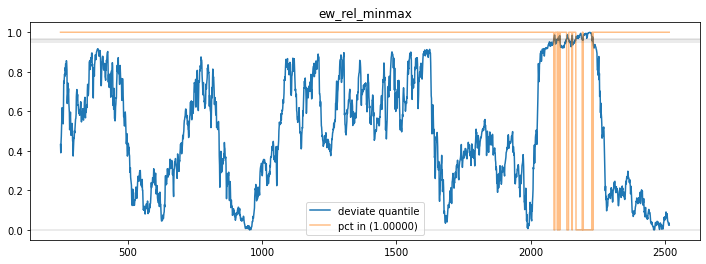

Saving mine2 params...


In [21]:
SD = 0.2213282
N_RAND = 20
N_ADJ = 180

#N_RAND = 5
#N_ADJ = 45

print('SD:', SD)
do_nothing_returns = {}
for stock in batch + ['mine1', 'mine2']: # 
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(
            stock_data, 
            N_CUTS, 
            best_param_set=best_params, 
            best_returns=best_returns, 
            sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        ###
        for method in ['ma', 'ew_ma', 'rel_minmax', 'ew_rel_minmax']:
            qp.plot_best(method, stock=method == 'ma')
        ###
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
        do_nothing_returns[stock] = qp.do_nothing_returns
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [22]:
def get_summary(stocks):
    best_returns = {}
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {best_pct:.8f} in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.4f} - {upper:.4f}): {pct:.4f}')
            best_returns[stock] = {'best_return': best_return, 'pct_in': best_pct}
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue
    return best_returns

In [23]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
best_returns = get_summary(batch + ['mine1', 'mine2'])
best_returns


^GSPC:
  Best Return: 2.62093244744254 (ew_rel_minmax)
  1.00000000 in
time param: 251
qs:
(0.0000 - 0.9775): 1.0000
(0.9775 - 0.9848): 1.0000
(0.9848 - 0.9864): 0.0090
(0.9864 - 1.0000): 0.0007

^IXIC:
  Best Return: 3.798417557820004 (ew_ma)
  1.00000000 in
time param: 251
qs:
(0.0000 - 0.9629): 1.0000
(0.9629 - 0.9641): 1.0000
(0.9641 - 0.9791): 0.0020
(0.9791 - 1.0000): 0.0000

^NYA:
  Best Return: 1.6173509118473408 (ma)
  1.00000000 in
time param: 251
qs:
(0.0000 - 0.2907): 1.0000
(0.2907 - 0.9833): 0.9995
(0.9833 - 0.9972): 0.9858
(0.9972 - 1.0000): 0.0007

^W5000:
  Best Return: 2.573416762407595 (ew_ma)
  1.00000000 in
time param: 251
qs:
(0.0000 - 0.9173): 1.0000
(0.9173 - 0.9246): 0.9999
(0.9246 - 0.9299): 0.0007
(0.9299 - 1.0000): 0.0000

mine1:
  Best Return: 15.365887188829788 (ew_ma)
  1.00000000 in
time param: 251
qs:
(0.0000 - 0.9560): 1.0000
(0.9560 - 0.9562): 1.0000
(0.9562 - 0.9638): 0.0010
(0.9638 - 1.0000): 0.0000

mine2:
  Best Return: 7.1381969398742875 (ew_ma)

{'^GSPC': {'best_return': 2.62093244744254, 'pct_in': 1.0},
 '^IXIC': {'best_return': 3.798417557820004, 'pct_in': 1.0},
 '^NYA': {'best_return': 1.6173509118473408, 'pct_in': 1.0},
 '^W5000': {'best_return': 2.573416762407595, 'pct_in': 1.0},
 'mine1': {'best_return': 15.365887188829788, 'pct_in': 1.0},
 'mine2': {'best_return': 7.1381969398742875, 'pct_in': 1.0}}

In [24]:
for stock in batch + ['mine1', 'mine2']:
    num = best_returns[stock]['best_return']
    den = do_nothing_returns[stock]
    weight = (num / den) - 1
    if weight <= 0:
        weight = 0
    if stock.startswith('mine'):
        weight /= 2
    best_returns[stock]['weight'] = weight
best_returns

{'^GSPC': {'best_return': 2.62093244744254,
  'pct_in': 1.0,
  'weight': 0.11270252504453682},
 '^IXIC': {'best_return': 3.798417557820004,
  'pct_in': 1.0,
  'weight': 0.16518626654627555},
 '^NYA': {'best_return': 1.6173509118473408,
  'pct_in': 1.0,
  'weight': 0.03172166403910559},
 '^W5000': {'best_return': 2.573416762407595,
  'pct_in': 1.0,
  'weight': 0.15517043189282198},
 'mine1': {'best_return': 15.365887188829788,
  'pct_in': 1.0,
  'weight': 0.09449499785832582},
 'mine2': {'best_return': 7.1381969398742875,
  'pct_in': 1.0,
  'weight': 0.22272610029122464}}

In [25]:
with open(f'{DATA}/qp_{N_YEARS}_weights.json', 'w') as f:
    json.dump(best_returns, f)

In [26]:
!say qp 10 is dunzo